# Check rubert-tiny2 tuned for emotion recognition on russian dataset (cause the model is bilingual and cool)

In [1]:
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt



In [2]:

# Load the dataset
dataset = load_dataset('dair-ai/emotion')

# Convert to pandas dataframe
train_data = pd.DataFrame(dataset['train'])
val_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

print(train_data.head())
print(test_data.head())

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0


In [3]:
train_data['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [4]:
train_data = train_data.drop_duplicates(subset='text')
train_data = train_data.reset_index(drop=True)

In [5]:
train_data.isna().values.any()

False

In [6]:
train_data['len'] = [len(text.split()) for text in train_data['text']]

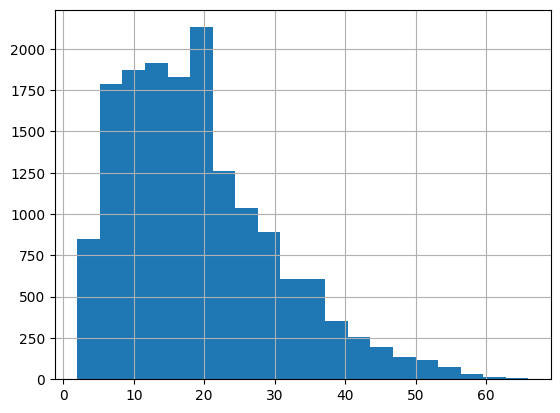

In [7]:
train_data['len'].hist(bins=20)
plt.show()

# Training

In [8]:
from transformers import BertForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold




import torch
import torch.nn as nn
import numpy as np


In [9]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection")
model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection", num_labels=6)


In [10]:
import torch
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [11]:
train_dataset = CustomDataset(train_data['text'], train_data['label'])
val_dataset = CustomDataset(val_data['text'], val_data['label'])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
device = torch.device('cuda:4')
# device = torch.device('cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

epochs = 15
best_score = 0

Epoch:  14
62


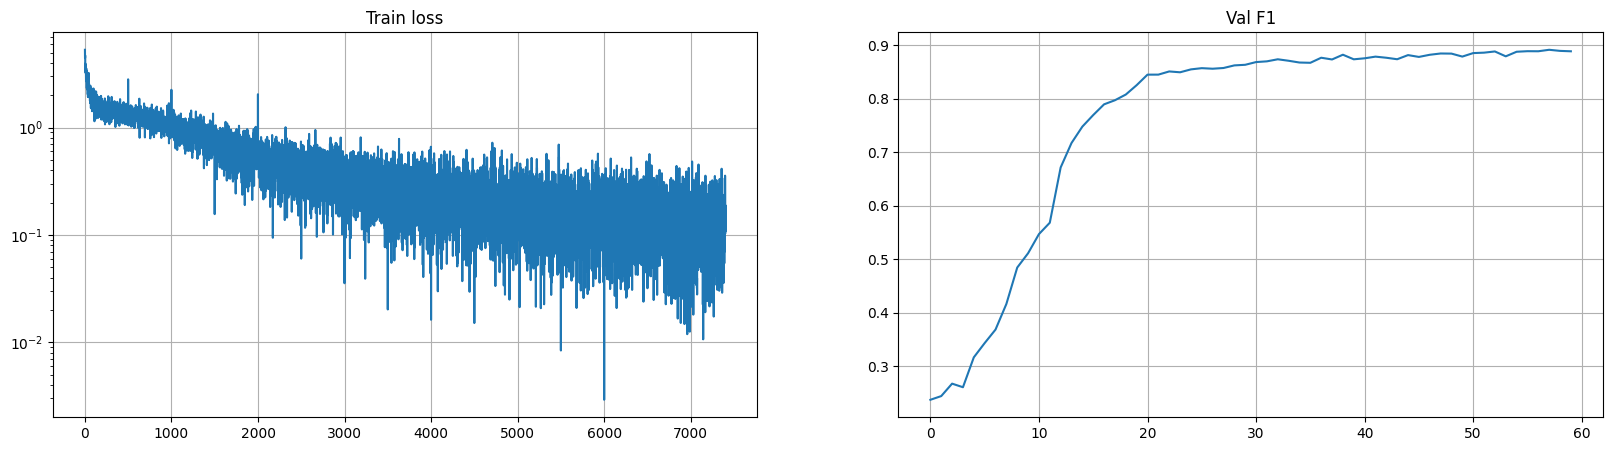

In [13]:
train_loss = []
val_metrics = []


for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        model.train()
        inputs = tokenizer(list(batch[0]), 
                           max_length=512, 
                           truncation=True,
                           padding='longest',
                           return_tensors='pt').to(device)
        logits = model(**inputs).logits
        loss = nn.CrossEntropyLoss()(logits, batch[1].to(device))
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss.append(loss.item())
        
        if i % 100 == 0 and i != 0:
            model.eval()
            labels = np.array([])
            preds = np.array([])
            for i, batch in enumerate(tqdm(val_dataloader)):
                inputs = tokenizer(list(batch[0]), 
                                   max_length=512, 
                                   truncation=True,
                                   padding='longest',
                                   return_tensors='pt').to(device)
                with torch.no_grad():
                    logits = model(**inputs).logits
                preds = np.append(preds,
                                torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
                labels = np.append(labels, batch[1].numpy())
                
            score = f1_score(preds, labels, average='macro')
            if score > best_score:
                model.save_pretrained('rubert-tiny-emotions')
                tokenizer.save_pretrained('rubert-tiny-emotions')
                best_score = score
                
            val_metrics.append(score)

            #print plots
            clear_output()
            print('Epoch: ', epoch)
            print(i)
            plt.figure(figsize=(20,5))
            plt.subplot(121)
            plt.semilogy(train_loss)
            plt.title('Train loss')
            plt.grid(True)
            plt.subplot(122)
            plt.plot(val_metrics)
            plt.title('Val F1')
            plt.grid(True)
            plt.show()
                
                
                    

                
        

# Inference

In [14]:
#load best model
model = BertForSequenceClassification.from_pretrained('rubert-tiny-emotions')
model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

## Validation data

In [15]:
test_dataset = CustomDataset(test_data['text'], test_data['label'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
#inference
model.to('cuda:0')
labels = np.array([])
preds = np.array([])
for i, batch in enumerate(tqdm(val_dataloader)):
    inputs = tokenizer(list(batch[0]), 
                       max_length=512, 
                       truncation=True,
                       padding='longest',
                       return_tensors='pt').to('cuda:0')
    with torch.no_grad():
        logits = model(**inputs).logits
    preds = np.append(preds,
                    torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
    labels = np.append(labels, batch[1].numpy())

f1_score(preds, labels, average='macro')

  0%|          | 0/63 [00:00<?, ?it/s]

0.891124957002936

In [23]:
len(labels)

2000

In [24]:
#val data
names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, list(labels), output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.943636,0.943636,0.943636,550.000
joy,0.904830,0.960784,0.931968,663.000
love,0.898876,0.824742,0.860215,194.000
anger,0.909091,0.883392,0.896057,283.000
fear,0.877358,0.861111,0.869159,216.000
surprise,0.913580,0.787234,0.845714,94.000
accuracy,0.913000,0.913000,0.913000,0.913
macro avg,0.907895,0.876817,0.891125,2000.000
weighted avg,0.912971,0.913000,0.912298,2000.000


## Test data

In [18]:
#inference
labels = np.array([])
preds = np.array([])
for i, batch in enumerate(tqdm(test_dataloader)):
    inputs = tokenizer(list(batch[0]), 
                       max_length=512, 
                       truncation=True,
                       
                       padding='longest',
                       return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    preds = np.append(preds,
                    torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
    labels = np.append(labels, batch[1].numpy())

f1_score(preds, labels, average='macro')

  0%|          | 0/63 [00:00<?, ?it/s]

0.873010313465708

In [19]:
#val data
names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, list(labels), output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.939759,0.962963,0.951220,567.000
joy,0.928058,0.945748,0.936819,682.000
love,0.849057,0.784884,0.815710,172.000
anger,0.927273,0.913978,0.920578,279.000
fear,0.906250,0.867521,0.886463,234.000
surprise,0.727273,0.727273,0.727273,66.000
accuracy,0.916000,0.916000,0.916000,0.916
macro avg,0.879611,0.867061,0.873010,2000.000
weighted avg,0.915294,0.916000,0.915414,2000.000


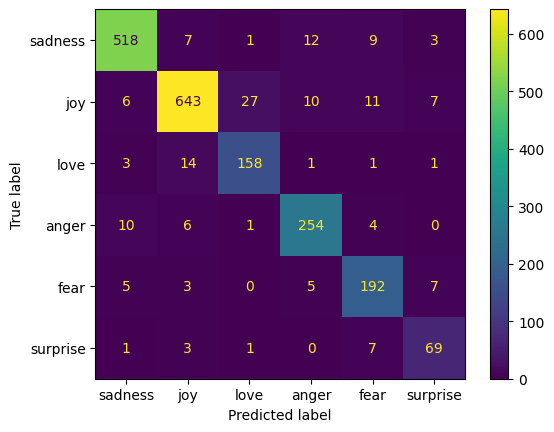

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(list(labels), preds )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
                              )
disp.plot()

plt.show()